In [1]:
import syft as sy

# 1. Join Duet session

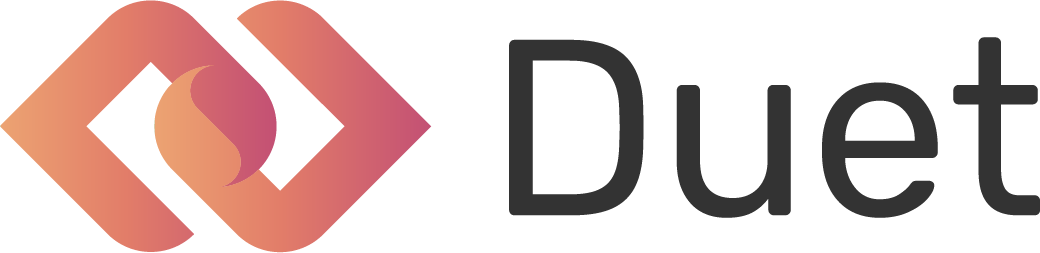

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


/Users/davebuckley/miniconda3/envs/openmined-courses/lib/python3.9/site-packages/aiortc/rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
/Users/davebuckley/miniconda3/envs/openmined-courses/lib/python3.9/site-packages/aiortc/rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

# 2. Search for data

In [3]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 55e415263d574a2886bedf6457d8c677>,[iris-data],"150 flowers, 4 features used",<class 'torch.Tensor'>
1,<UID: 29ab22ed406b462abba600dabc27c928>,[iris-target],3 classes of Iris,<class 'torch.Tensor'>
2,<UID: f76c36ec59484ec7a403f7f55048738d>,[iris-data],"150 flowers, 4 features used",<class 'torch.Tensor'>
3,<UID: 8d977c7d9c5b4f7caafda042592ba6be>,[iris-target],3 classes of Iris,<class 'torch.Tensor'>


In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

In [5]:
print(data_ptr)
print(target_ptr)

# Perform regression on the dataset

In [6]:
# Data scientist needs to know size and number of features/targets
print(duet.store.pandas["Description"][0])
print(duet.store.pandas["Description"][1])

150 flowers, 4 features used
3 classes of Iris


In [7]:
import torch

In [8]:
in_dim = 4
out_dim = 3
n_samples = 150

In [9]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20) # defines input/output layers and neurons
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)
        
    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output
    
# log_softmax means you are returned the class with the highest probability, rather than a full distribution over the three possible classes

In [10]:
local_model = SyNet(torch)

In [11]:
remote_model = local_model.send(duet)

In [15]:
remote_torch = duet.torch

In [16]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)
print(params)
print(optim) # remote_torch, so they return pointers to the remote objects

In [17]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):
    losses = []
    for i in range(iterations):
        optim.zero_grad()
        output = model(data_ptr)
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        loss_item = loss.item()
        
        loss_value =  loss_item.get(reason="To evaluate training progress", request_block=True, timeout_secs=5)
        
        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)
        losses.append(loss_value)
        
        loss.backward()
        optim.step()
    return losses

In [19]:
iterations = 50
losses = train(iterations, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 1.1588537693023682
Epoch 10 loss 0.6634626984596252
Epoch 20 loss 0.23226620256900787
Epoch 30 loss 0.09253562241792679
Epoch 40 loss 0.06389955431222916


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

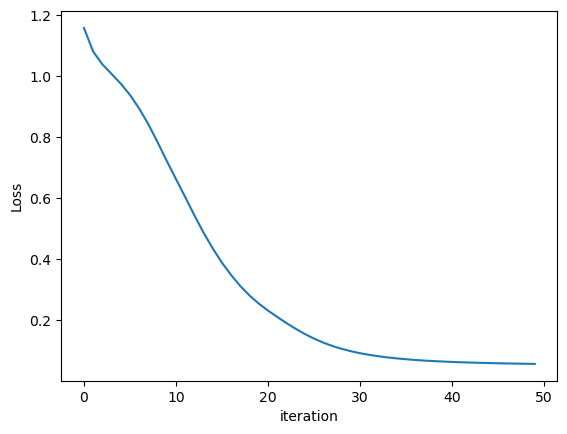

In [22]:
plt.plot(range(iterations), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

# Download remote model to local machine

In [23]:
def get_local_model(model):
    if  not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs = 5
        )
    else:
        local_model = model
    return local_model

local_model = get_local_model(remote_model)

# Test on local data

In [24]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [25]:
iris_test = pd.read_csv("./data/iris-test.csv")
iris_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.0,2.7,5.1,1.6,1
3,6.0,2.9,4.5,1.5,1
4,5.8,2.7,5.1,1.9,2


In [27]:
X_test = iris_test.loc[:, iris_test.columns != "species"]
y_test = iris_test["species"]

In [28]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [29]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 1
Prediction: 1 Ground truth: 1
Prediction: 2 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 1 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 1 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 2 Ground truth: 2
Prediction: 2 Ground truth: 2


In [30]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc*100)

Overall test accuracy 93.33333333333333
